In [1]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from plotnine import (element_blank, scale_color_manual, scale_x_continuous, ggplot, aes, geom_line ,geom_bar, geom_point, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
# defin path and load train and test data 
final_data_path = 'final data/'
tr = pd.read_csv(final_data_path + 'train_data_final.csv', index_col = 0)
te = pd.read_csv(final_data_path + 'test_data_final.csv', index_col = 0)
gc.collect()

0

In [3]:
# train_x, train_y 
tr = tr.sample(frac = 1)
x = tr.drop(['Id', 'Response'], axis = 1)
y = tr['Response']
print(x.shape)
print(y.shape)

(1183747, 55)
(1183747,)


In [18]:
def best_thr_mcc(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.30, 0.55, 7)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_thr = thresholds[np.argmax(mcc)]
    best_score = mcc.max()
    return best_thr, best_score

# customed eval_metric


def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    thresholds = np.linspace(0.30, 0.55, 7)
    mcc = np.array([matthews_corrcoef(labels, preds > thr)
                   for thr in thresholds])
    best_score = mcc.max()
    return 'MCC', best_score, True

In [19]:
def hp_train_model(x: pd.DataFrame, y: pd.DataFrame, early_stopping_rounds, params = None):
    
    mcc_scores = []
    evals_result = {}

    tr_x, va_x, tr_y, va_y = train_test_split(x, y, test_size = 0.2, random_state = 70)
    dtrain = lgb.Dataset(data = tr_x, label = tr_y)
    dvalid = lgb.Dataset(data = va_x, label = va_y, reference = dtrain)
    watchlist = [dtrain, dvalid]

    print('='*40)
    print('curent hyperparameters: ', params)
    print('='*40)

    model = lgb.train(params = params, 
                      train_set = dtrain, 
                      valid_sets = watchlist,
                      valid_names=['train', 'eval'],
                      verbose_eval=1, 
                      early_stopping_rounds=early_stopping_rounds, 
                      evals_result=evals_result,
                      feval = evalerror
                      )
        
    va_pred = model.predict(va_x)
    _, mcc_value= best_thr_mcc(va_pred, dvalid)
    mcc_scores.append(mcc_value)

    history.append((params, mcc_value))

    print('='*40)
    print('mcc value: {}'.format(round(mcc_value, 3)))
    print('='*40)
    gc.collect()

    return np.mean(mcc_scores)

def hp_lgb_model(params):
    
    early_stopping_rounds = int(round(3/ (1/params['eta']), 0))

    lgb_params = {'feature_fraction': params['feature_fraction'], 
                  'num_iteration': int(params['num_iteration']),
                  'eta': 1/params['eta'],
                  'max_depth': int(params['max_depth']),
                  'bagging_fraction': params['bagging_fraction'],
                  'min_child_weight': int(params['min_child_weight']), 
                  'num_leaves': int(params['num_leaves']),
                  'min_data_in_leaf': int(params['min_data_in_leaf']),
                  'objective': 'binary',
                  'random_state': 123,
                  'metric': 'None',
                  'early_stopping_rounds': early_stopping_rounds,
                  }
                        
    score = hp_train_model(x = x, y = y,  
                           early_stopping_rounds = early_stopping_rounds, 
                           params = lgb_params)
    return {'loss': -score, 'status': STATUS_OK }


In [ ]:
space = {
        'num_iteration': hp.quniform('num_iteration', 100, 500, 100),
        "min_child_weight": hp.quniform('min_child_weight', 8, 22, 4),
        'eta'      : hp.uniform('eta', 3, 11),
        'max_depth': hp.quniform('max_depth', 8, 28, 6),
        "num_leaves": hp.quniform('num_leaves', 12, 26, 6),
        "feature_fraction": hp.quniform("feature_fraction", 0.7, 0.95, 0.05),
        "bagging_fraction": hp.quniform("bagging_fraction", 0.7, 0.95, 0.05),
        "min_data_in_leaf": hp.quniform('min_data_in_leaf', 8, 28, 6),
    }

history = []
trials = Trials()
best = fmin(fn = hp_lgb_model, space = space, algo = tpe.suggest, max_evals = 65, trials = trials)
print('='*40)
print(best)
# sorted(history, key = lambda x:x[1])[-1]

In [26]:
def train_model(x: pd.DataFrame, y: pd.DataFrame, n_fold: int, early_stopping_rounds:int, params = None, te = te):
    
    kf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 123)

    scores = {'fold':[], 'mcc':[], 'g_means':[], 'auc_scores':[], 'f1_scores':[], 'threshold':[]}

    evals_result = {}
    loss_data = pd.DataFrame()
    #roc_data  = pd.DataFrame()
    predictions = np.zeros(len(te))
    feature_importances = 0

    for fold_i, (tr_idx, va_idx) in enumerate(kf.split(x, y)):
    
        temp_loss_data = pd.DataFrame()
        #temp_roc_data  = pd.DataFrame()

        tr_x, va_x = x.iloc[tr_idx], x.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

        dtrain = lgb.Dataset(data = tr_x, label = tr_y)
        dvalid = lgb.Dataset(data = va_x, label = va_y, reference = dtrain)
        watchlist = [dtrain, dvalid]

        model = lgb.train(params = params, 
                          train_set = dtrain, 
                          valid_sets = watchlist,
                          valid_names=['train', 'eval'],
                          verbose_eval=1, 
                          early_stopping_rounds=early_stopping_rounds, 
                          evals_result=evals_result,
                          feval = evalerror
                          )
        
        va_pred = model.predict(va_x)

        #temp_roc_data = pd.DataFrame({'va_test':va_y, 'va_pred':va_pred})

        prediction = model.predict(te.drop(['Id'], axis = 1))
        predictions += prediction

        feature_importances_ = model.feature_importance(importance_type = 'gain')
        feature_importances += feature_importances_
        
        if (fold_i + 1) == n_fold:
            predictions /= (fold_i + 1)
            feature_importances /= (fold_i + 1)

        best_thresh, mcc_value= best_thr_mcc(va_pred, dvalid)
        y_pred = np.array([1 if y_pro > best_thresh else 0 for y_pro in va_pred])

        tn, fp, fn, tp = confusion_matrix(va_y, y_pred).ravel()
        spec = tn / (tn + fp)
        sens = tp / (tp + fn)
        g_means = np.sqrt(spec * sens)
        fmeasure = f1_score(va_y, y_pred)
        auc_score = roc_auc_score(va_y, y_pred)

        temp_loss_data = pd.DataFrame({'train': list(evals_result['train'].values())[0],
                                       'test': list(evals_result['eval'].values())[0],
                                       'tree': [i+1 for i in range(len(list(evals_result['train'].values())[0]))]})

        print('mcc value: {}'.format(round(mcc_value, 3)))
        print('g_means value: {}'.format(round(g_means, 3)))
        print('auc value: {}'.format(round(auc_score, 3)))
        print('f1_score value: {}'.format(round(fmeasure, 3)))
        print('threshold: {}'.format(round(best_thresh, 3)))
        
        loss_data = pd.concat([loss_data, temp_loss_data], axis = 0).reset_index(drop=True)
        scores['fold'].append(fold_i + 1)
        scores['mcc'].append(mcc_value)
        scores['g_means'].append(g_means)
        scores['f1_scores'].append(fmeasure)
        scores['auc_scores'].append(auc_score)
        scores['threshold'].append(best_thresh)
        
        gc.collect()
    
    return model, scores, loss_data, predictions, feature_importances

def lgb_model(params):
    
    n_fold = 5
    early_stopping_rounds = int(round(5/ (1/params['eta']), 0))

    lgb_params = {'feature_fraction': params['feature_fraction'], 
                  'num_iteration': int(params['num_iteration']),
                  'eta': 1/params['eta'],
                  'max_depth': int(params['max_depth']),
                  'bagging_fraction': params['bagging_fraction'],
                  'min_child_weight': int(params['min_child_weight']), 
                  'num_leaves': int(params['num_leaves']),
                  'min_data_in_leaf': int(params['min_data_in_leaf']),
                  'objective': 'binary',
                  'random_state': 123,
                  'metric': 'None',
                  'early_stopping_rounds': early_stopping_rounds
                  }
                        
    model, scores, loss_data, predictions, feature_importances = train_model(x = x, y = y, n_fold = n_fold, 
                                                                             early_stopping_rounds = early_stopping_rounds, 
                                                                             params = lgb_params)
    return model, scores, loss_data, predictions, feature_importances

In [27]:
model, scores, loss_data, predictions, feature_importances = lgb_model(best)
pd.DataFrame(scores)

c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 5503, number of negative: 941494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7221
[LightGBM] [Info] Number of data points in the train set: 946997, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005811 -> initscore=-5.142175
[LightGBM] [Info] Start training from score -5.142175
[1]	train's MCC: 0.252922	eval's MCC: 0.270731
Training until validation scores don't improve for 45 rounds
[2]	train's MCC: 0.261461	eval's MCC: 0.274648
[3]	train's MCC: 0.300688	eval's MCC: 0.315136
[4]	train's MCC: 0.298617	eval's MCC: 0.310993
[5]	train's MCC: 0.321134	eval's MCC: 0.33834
[6]	train's MCC: 0.343256	eval's MCC: 0.361755
[7]	train's MCC: 0.36357	eval's MCC: 0.377088
[8]	train's MCC: 0.372782	eval's MCC: 0.389524
[9]

c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 5503, number of negative: 941494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7215
[LightGBM] [Info] Number of data points in the train set: 946997, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005811 -> initscore=-5.142175
[LightGBM] [Info] Start training from score -5.142175
[1]	train's MCC: 0.263828	eval's MCC: 0.233481
Training until validation scores don't improve for 45 rounds
[2]	train's MCC: 0.271343	eval's MCC: 0.243609
[3]	train's MCC: 0.293876	eval's MCC: 0.269989
[4]	train's MCC: 0.29986	eval's MCC: 0.275728
[5]	train's MCC: 0.331323	eval's MCC: 0.300752
[6]	train's MCC: 0.355377	eval's MCC: 0.331409
[7]	train's MCC: 0.362474	eval's MCC: 0.341604
[8]	train's MCC: 0.372188	eval's MCC: 0.348931
[9

c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 5504, number of negative: 941494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7243
[LightGBM] [Info] Number of data points in the train set: 946998, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005812 -> initscore=-5.141993
[LightGBM] [Info] Start training from score -5.141993
[1]	train's MCC: 0.233837	eval's MCC: 0.228074
Training until validation scores don't improve for 45 rounds
[2]	train's MCC: 0.242582	eval's MCC: 0.238884
[3]	train's MCC: 0.281876	eval's MCC: 0.283197
[4]	train's MCC: 0.286288	eval's MCC: 0.291944
[5]	train's MCC: 0.324961	eval's MCC: 0.319924
[6]	train's MCC: 0.352872	eval's MCC: 0.350293
[7]	train's MCC: 0.368422	eval's MCC: 0.368895
[8]	train's MCC: 0.371912	eval's MCC: 0.371368
[

c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 5503, number of negative: 941495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7253
[LightGBM] [Info] Number of data points in the train set: 946998, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005811 -> initscore=-5.142176
[LightGBM] [Info] Start training from score -5.142176
[1]	train's MCC: 0.259473	eval's MCC: 0.261388
Training until validation scores don't improve for 45 rounds
[2]	train's MCC: 0.26701	eval's MCC: 0.270971
[3]	train's MCC: 0.291541	eval's MCC: 0.288978
[4]	train's MCC: 0.305804	eval's MCC: 0.30306
[5]	train's MCC: 0.326944	eval's MCC: 0.316804
[6]	train's MCC: 0.348192	eval's MCC: 0.335934
[7]	train's MCC: 0.365299	eval's MCC: 0.349021
[8]	train's MCC: 0.377345	eval's MCC: 0.356886
[9]

c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
c:\py_venv\tutorial-venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 5503, number of negative: 941495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 946998, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005811 -> initscore=-5.142176
[LightGBM] [Info] Start training from score -5.142176
[1]	train's MCC: 0.257343	eval's MCC: 0.270624
Training until validation scores don't improve for 45 rounds
[2]	train's MCC: 0.26495	eval's MCC: 0.27683
[3]	train's MCC: 0.282623	eval's MCC: 0.292433
[4]	train's MCC: 0.306035	eval's MCC: 0.31386
[5]	train's MCC: 0.318331	eval's MCC: 0.344508
[6]	train's MCC: 0.340756	eval's MCC: 0.36303
[7]	train's MCC: 0.36544	eval's MCC: 0.379217
[8]	train's MCC: 0.371518	eval's MCC: 0.387364
[9]	tr

,fold,mcc,g_means,auc_scores,f1_scores,threshold
0,1,0.453798,0.496285,0.623047,0.381113,0.466667
1,2,0.436017,0.494788,0.622257,0.372994,0.425000
2,3,0.455229,0.518622,0.634318,0.399568,0.383333
3,4,0.433263,0.507792,0.628723,0.381720,0.341667
4,5,0.460021,0.507850,0.628838,0.393134,0.425000


c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371875125970764.svg


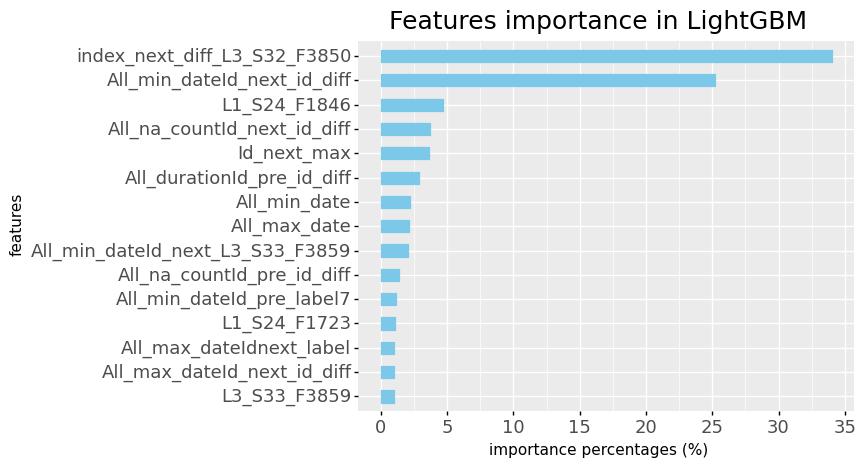

<ggplot: (-9223371875125970764)>

In [38]:
keys = list(x.columns)
values = list(feature_importances)
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))

g = (
    ggplot(feat_imp.iloc[-15:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=13),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = np.arange(0, 100, 5))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance in LightGBM')
)
ggsave(file="Features importance in LightGBM.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371875123051616.svg


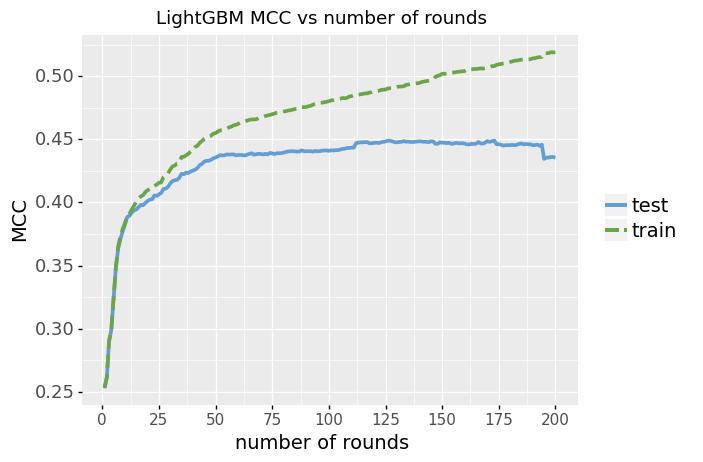

<ggplot: (-9223371875123051616)>

In [39]:
loss_data[['train', 'test']] = loss_data[['train', 'test']]
loss_data = loss_data.groupby('tree')['train', 'test'].mean().reset_index()
loss_data = pd.melt(loss_data, id_vars = ['tree'], value_vars = ['train', 'test'])
loss_data['variable'] = loss_data['variable'].astype('category')

g = (ggplot(loss_data, aes(x = 'tree', y = 'value', group = 'variable', color = 'variable', linetype = 'variable')) 
     + geom_line(size = 1.5)
    #  + geom_smooth(method = 'lm') 
     + theme(axis_text_x = element_text(size = 11),
             axis_text_y = element_text(size = 13),
             axis_title = element_text(size = 14),
             legend_text = element_text(size = 14),
             legend_title = element_blank())
     + scale_x_continuous(breaks = range(0, 205, 25))
     + scale_y_continuous(breaks = np.linspace(0, 1.0, 21, endpoint = True))
     + scale_color_manual(values=["#619ED6", "#6BA547"])
     + labs(x = 'number of rounds', y = 'MCC')
     + ggtitle('LightGBM MCC vs number of rounds')
    )
ggsave(file="LightGBM MCC vs number of rounds.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [36]:
path = 'model/4.LightGBM/'
pd.DataFrame({'parameters': best}).to_csv(path + 'best_parameters.csv', index = True)
# best = pd.read_csv(path + 'best_parameters.csv', index_col = 0).to_dict

pd.DataFrame(scores).to_csv(path + 'LightGBM_scores.csv', index = False)
loss_data.to_csv(path + 'LightGBM_loss_data.csv', index = False)
model.save_model(path + "LightGBM_model.json")

# private: 0.46074
submission = pd.DataFrame({'Id': te['Id'], 'Response': predictions > np.mean(scores['threshold'])})
submission['Response'] = submission['Response'].astype('int')
submission.to_csv(path + 'submission_LightGBM.csv', index = 0)